In [1]:
import pandas as pd
import numpy as np
from glob import glob
from pathlib import Path
import pynmea2
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from tqdm.notebook import tqdm
import copy

In [2]:
files_list = glob(r'../../Data/Caravela/CaravelaPCS/Datalog/Y20/*/*'+ '/*recordDataPort_D*')  
files_list.sort()
li = []

for filename in tqdm(range(4,len(files_list))): # take files from Caravelas launch onwards
    with open(files_list[filename],'r') as myfile:
        content = myfile.readlines()[1:-1] #skip first line of file as this is likey to have not been written correctly
    frame = pd.DataFrame(data = np.array(content), columns= ['original'])
    li.append(frame)
df = pd.concat(li, axis=0,ignore_index=True)

In [3]:
del frame, content, li # clear the things we dont need open
myfile.close()

In [4]:
df['nmea_ident'] = copy.deepcopy(df.original.str[16:22]) #create a new column of the nmea string code
df['desired'] = False #create column to decide which rows to keep
df.loc[df['nmea_ident'] == '$WIMDA', 'desired'] = True #set the rows with the desired nmea string identity to true
des = df[df.desired] # create new dataframe with desired rows

In [5]:
des = des.reset_index() #tidy up the new dataframe
des = des.drop(['index'], axis=1)

In [6]:
strings = [] # create empty list to hold nmea strings 
des['NMEA'] = '' #create new column in dataframe
for i in tqdm(range(len(des['original']))): 
    try: 
        nmea = pynmea2.parse(des['original'][i][16:], check=True) #parse nmea string and check the checksum is correct
    except ValueError:
        nmea = np.nan # replace errors with nan
    strings.append(nmea)
des['NMEA'] = strings #populate the dataframe

In [7]:
des

,original,nmea_ident,desired,NMEA
0,"200122,12:04:48,$WIMDA,29.9493,I,1.0142,B,23.0...",$WIMDA,True,"$WIMDA,29.9493,I,1.0142,B,23.0,C,,,,,,,,,,,,,,*3B"
1,"200122,12:04:49,$WIMDA,29.9493,I,1.0142,B,23.0...",$WIMDA,True,"$WIMDA,29.9493,I,1.0142,B,23.0,C,,,,,,,,,,,,,,*3B"
2,"200122,12:04:50,$WIMDA,29.9493,I,1.0142,B,23.0...",$WIMDA,True,"$WIMDA,29.9493,I,1.0142,B,23.0,C,,,,,,,,,,,,,,*3B"
3,"200122,12:04:51,$WIMDA,29.9493,I,1.0142,B,23.0...",$WIMDA,True,"$WIMDA,29.9493,I,1.0142,B,23.0,C,,,,,,,,,,,,,,*3B"
4,"200122,12:04:52,$WIMDA,29.9493,I,1.0142,B,23.0...",$WIMDA,True,"$WIMDA,29.9493,I,1.0142,B,23.0,C,,,,,,,,,,,,,,*3B"
...,...,...,...,...
2837411,"200224,14:20:18,$WIMDA,30.0409,I,1.0173,B,25.7...",$WIMDA,True,"$WIMDA,30.0409,I,1.0173,B,25.7,C,,,,,,,,,,,,,,*3A"
2837412,"200224,14:20:19,$WIMDA,30.0409,I,1.0173,B,25.7...",$WIMDA,True,"$WIMDA,30.0409,I,1.0173,B,25.7,C,,,,,,,,,,,,,,*3A"
2837413,"200224,14:20:20,$WIMDA,30.0409,I,1.0173,B,25.7...",$WIMDA,True,"$WIMDA,30.0409,I,1.0173,B,25.7,C,,,,,,,,,,,,,,*3A"
2837414,"200224,14:20:21,$WIMDA,30.0409,I,1.0173,B,25.7...",$WIMDA,True,"$WIMDA,30.0409,I,1.0173,B,25.7,C,,,,,,,,,,,,,,*3A"


In [8]:
parsed = [] #create emptry list for parsed datetimes
des['datetime'] = ''
for i in tqdm(range(len(des['original']))):
    try: 
        time_in = ((datetime.strptime(des.original[i][:15], '%y%m%d,%H:%M:%S')))
    except ValueError:
        time_in = np.nan
    parsed.append(time_in)
des['datetime'] = parsed

In [9]:
des['pressure[bar]'] = ''
d=[]
for i in tqdm(range(len(des['NMEA']))):
    if type(des['NMEA'][i]) == pynmea2.types.talker.MDA:
        d.append(des['NMEA'][i].b_pressure_bar)
    else:
        d.append(np.nan)
des['pressure[bar]'] = d

In [10]:
des['pressure_unit'] = ''
d=[]
for i in tqdm(range(len(des['NMEA']))):
    if type(des['NMEA'][i]) == pynmea2.types.talker.MDA:
        d.append(des['NMEA'][i].bars)
    else:
        d.append(np.nan)
des['pressure_unit'] = d

In [17]:
des['air_temp[C]'] = ''
d=[]
for i in tqdm(range(len(des['NMEA']))):
    if type(des['NMEA'][i]) == pynmea2.types.talker.MDA:
        d.append(des['NMEA'][i].air_temp)
    else:
        d.append(np.nan)
des['air_temp[C]'] = d

In [12]:
des['temp_unit'] = ''
d=[]
for i in tqdm(range(len(des['NMEA']))):
    if type(des['NMEA'][i]) == pynmea2.types.talker.MDA:
        d.append(des['NMEA'][i].a_celsius)
    else:
        d.append(np.nan)
des['temp_unit'] = d

Check all temp and pressure units are deg celcius and bar

In [14]:
des.pressure_unit.unique()

array(['B', nan], dtype=object)

In [15]:
des.temp_unit.unique()

array(['C', nan], dtype=object)

In [20]:
des = des.drop(['original','nmea_ident','desired','NMEA','pressure_unit','temp_unit'], axis = 1)

In [21]:
des

,datetime,pressure[bar],air_temp[C]
0,2020-01-22 12:04:48,1.0142,23.0
1,2020-01-22 12:04:49,1.0142,23.0
2,2020-01-22 12:04:50,1.0142,23.0
3,2020-01-22 12:04:51,1.0142,23.0
4,2020-01-22 12:04:52,1.0142,23.0
...,...,...,...
2837411,2020-02-24 14:20:18,1.0173,25.7
2837412,2020-02-24 14:20:19,1.0173,25.7
2837413,2020-02-24 14:20:20,1.0173,25.7
2837414,2020-02-24 14:20:21,1.0173,25.7


# Plot the timeseries

In [22]:
import matplotlib.pyplot as plt
font_size=23
plt.rcParams.update({'font.size': font_size})

(array([18282., 18286., 18290., 18293., 18297., 18301., 18305., 18309.,
        18313., 18317.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

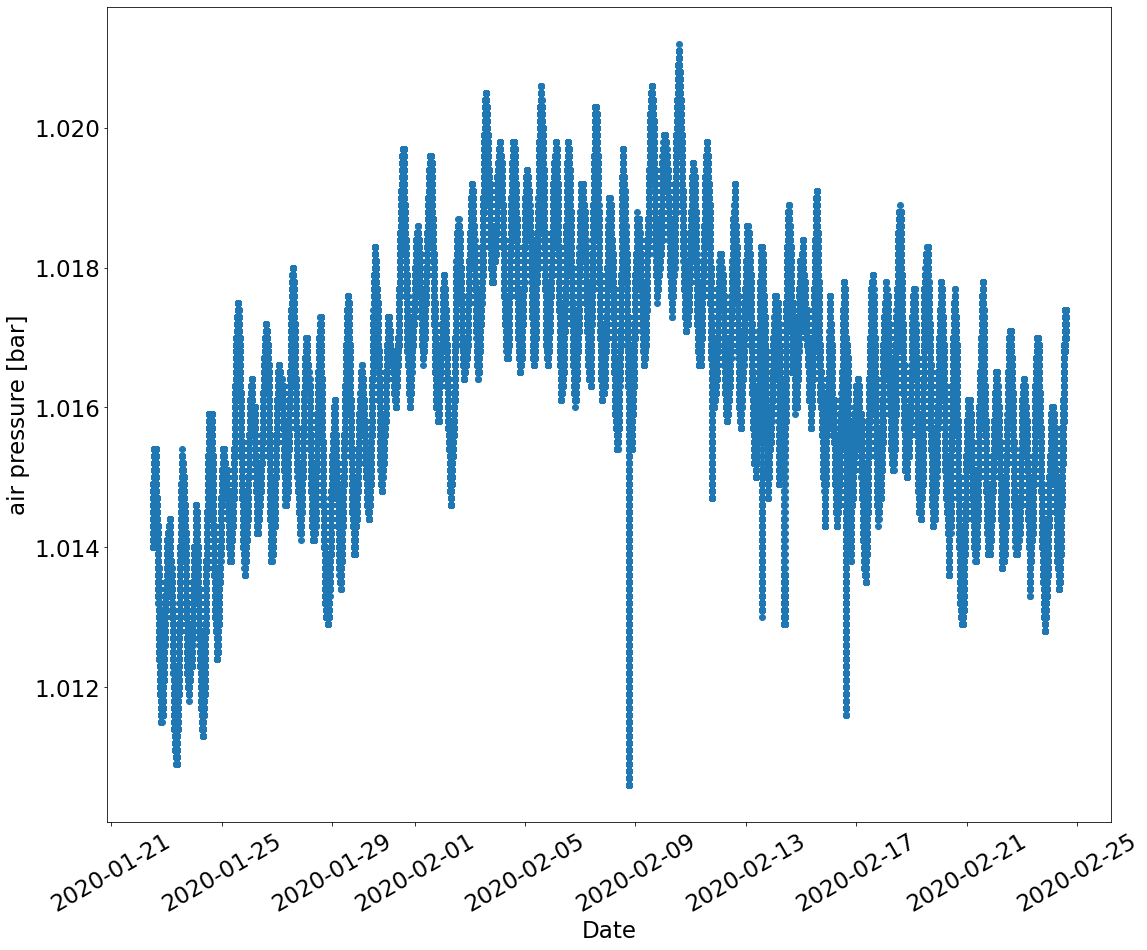

In [27]:
fig,ax = plt.subplots(1,1, figsize=(18, 15))
ax.scatter(des['datetime'], des['pressure[bar]'])
ax.set_ylabel("air pressure [bar]")
ax.set_xlabel('Date')
plt.xticks(rotation=30);

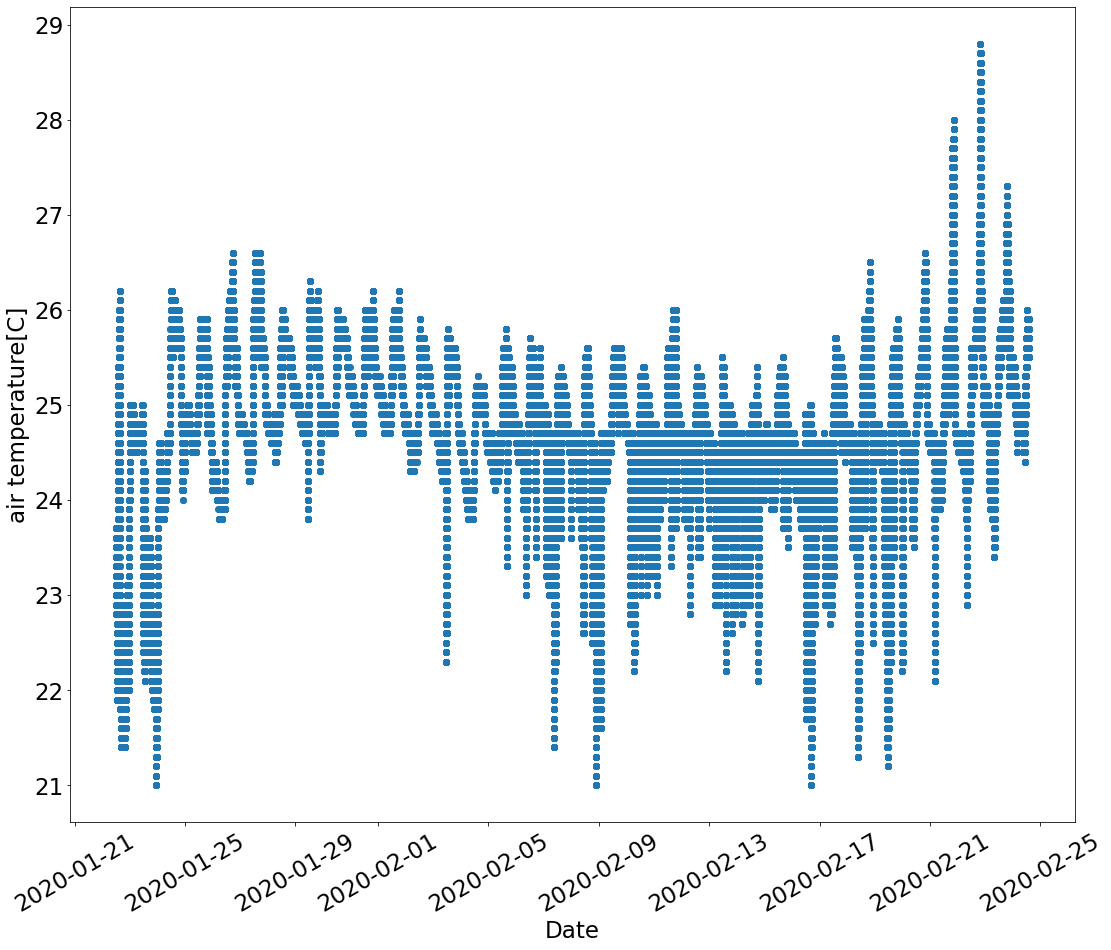

In [29]:
fig,ax = plt.subplots(1,1, figsize=(18, 15))
ax.scatter(des['datetime'], des['air_temp[C]'])
ax.set_ylabel("air temperature[C]")
ax.set_xlabel('Date')
plt.xticks(rotation=30);

# Change to isoformat datetime for distributing

In [ ]:
iso = []
for i in tqdm(range(len(des.datetime))):
    iso.append(relwind['datetime'][i].isoformat())
relwind['datetime[UTC]'] = iso